# Market Pattern Analysis for StockPredictionPro

This notebook analyzes historical market data to identify meaningful patterns and cycles which can be leveraged for trading strategies and risk management.

**Analysis Focus Areas:**
- **Seasonality Analysis**: Daily, weekly, monthly, and yearly patterns
- **Trend Decomposition**: Separating trend, seasonal, and residual components
- **Volatility Regimes**: Identifying high/low volatility periods for risk management
- **Cyclical Patterns**: Detecting recurring market cycles and behaviors
- **Multi-Asset Correlations**: Understanding asset relationships and clustering
- **Market Microstructure**: Intraday patterns and trading behaviors

**Objectives:**
- Extract actionable insights from historical price movements
- Identify predictable seasonal and cyclical patterns
- Understand volatility clustering and regime changes
- Support strategy development with data-driven pattern recognition
- Enable adaptive risk management based on market conditions

These insights form the foundation for developing robust trading strategies and improving model performance.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Time series analysis libraries
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning for pattern recognition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from scipy.signal import find_peaks

# Plotting configuration
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
%matplotlib inline

warnings.filterwarnings('ignore')

print('✅ Advanced libraries loaded for market pattern analysis')
print('📊 Ready for comprehensive pattern detection and analysis')


✅ Advanced libraries loaded for market pattern analysis
📊 Ready for comprehensive pattern detection and analysis


In [2]:
# Load historical market data with comprehensive error handling
try:
    market_df = pd.read_csv('../data/raw/market_data.csv', parse_dates=['date'], index_col='date')
    print('✅ Historical market data loaded successfully')
    print(f'   • Data range: {market_df.index.min().date()} to {market_df.index.max().date()}')
    print(f'   • Total records: {len(market_df):,}')
    
except FileNotFoundError:
    print('📝 Market data file not found. Generating realistic sample data...')
    
    # Generate sophisticated sample market data
    np.random.seed(42)
    n_days = 1500  # ~4 years of daily data
    start_date = '2020-01-01'
    dates = pd.date_range(start=start_date, periods=n_days, freq='D')
    
    # Create realistic price movements with multiple components
    initial_price = 100
    
    # 1. Long-term trend (slightly positive)
    trend = np.linspace(0, 20, n_days)
    
    # 2. Seasonal component (annual cycle)
    seasonal = 5 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)
    
    # 3. Weekly pattern (weaker on weekends)
    weekly = 2 * np.sin(2 * np.pi * np.arange(n_days) / 7)
    
    # 4. Random walk with varying volatility
    volatility = 0.8 + 0.4 * np.sin(2 * np.pi * np.arange(n_days) / 252)  # Annual volatility cycle
    random_component = np.cumsum(np.random.normal(0, volatility))
    
    # Combine all components
    prices = initial_price + trend + seasonal + weekly + random_component
    
    # Create OHLCV data
    market_df = pd.DataFrame(index=dates)
    market_df['close'] = prices
    market_df['open'] = market_df['close'].shift(1) + np.random.normal(0, 0.5, n_days)
    market_df['high'] = np.maximum(market_df['open'], market_df['close']) + np.abs(np.random.normal(0, 1, n_days))
    market_df['low'] = np.minimum(market_df['open'], market_df['close']) - np.abs(np.random.normal(0, 1, n_days))
    market_df['volume'] = np.random.lognormal(15, 0.5, n_days)
    
    # Ensure realistic OHLC relationships
    market_df['high'] = np.maximum(market_df['high'], market_df[['open', 'close']].max(axis=1))
    market_df['low'] = np.minimum(market_df['low'], market_df[['open', 'close']].min(axis=1))
    
    # Remove any NaN values
    market_df = market_df.dropna()
    
    print('✅ Sophisticated sample market data generated')
    print(f'   • Includes trend, seasonal, weekly, and volatility patterns')

# Calculate additional metrics for analysis
market_df['returns'] = market_df['close'].pct_change()
market_df['log_returns'] = np.log(market_df['close'] / market_df['close'].shift(1))

# Add date components for pattern analysis
market_df['year'] = market_df.index.year
market_df['month'] = market_df.index.month
market_df['quarter'] = market_df.index.quarter
market_df['day_of_week'] = market_df.index.dayofweek  # 0=Monday, 6=Sunday
market_df['day_of_month'] = market_df.index.day
market_df['day_of_year'] = market_df.index.dayofyear

print(f'\n📋 Market Data Overview:')
display(market_df.head(10))

print(f'\n📊 Basic Statistics:')
display(market_df[['close', 'returns', 'volume']].describe())


📝 Market data file not found. Generating realistic sample data...
✅ Sophisticated sample market data generated
   • Includes trend, seasonal, weekly, and volatility patterns

📋 Market Data Overview:


,close,open,high,low,volume,returns,log_returns,year,month,quarter,day_of_week,day_of_month,day_of_year
2020-01-02,101.948394,100.121778,102.808779,98.769270,2.384582e+06,NaN,NaN,2020,1,1,3,2,2
2020-01-03,102.964976,101.539295,103.378582,99.955706,2.041040e+06,0.009972,0.009922,2020,1,1,4,3,3
2020-01-04,103.246112,102.963289,105.133800,102.550290,2.485544e+06,0.002730,0.002727,2020,1,1,5,4,4
2020-01-05,101.413126,103.161020,103.717573,101.199059,2.937075e+06,-0.017754,-0.017913,2020,1,1,6,5,5
2020-01-06,100.231179,101.186512,102.521994,99.851773,4.968245e+06,-0.011655,-0.011723,2020,1,1,0,6,6
2020-01-07,102.073858,100.579372,102.559894,99.888900,2.784059e+06,0.018384,0.018217,2020,1,1,1,7,7
2020-01-08,104.403590,102.551511,105.950894,102.285894,1.479459e+06,0.022824,0.022567,2020,1,1,2,8,8
2020-01-09,105.653103,104.447794,106.735794,103.790031,5.780692e+06,0.011968,0.011897,2020,1,1,3,9,9
2020-01-10,106.620071,106.391868,107.091196,106.322335,2.151025e+06,0.009152,0.009111,2020,1,1,4,10,10
2020-01-11,105.219715,106.049227,106.142863,104.032722,3.174434e+06,-0.013134,-0.013221,2020,1,1,5,11,11



📊 Basic Statistics:


,close,returns,volume
count,1499.000000,1498.000000,1.499000e+03
mean,121.046410,0.000462,3.709984e+06
std,26.835097,0.013285,2.068610e+06
min,85.410263,-0.047827,6.531041e+05
25%,97.084730,-0.009362,2.263386e+06
50%,111.551362,0.000430,3.205629e+06
75%,148.766692,0.010173,4.651003e+06
max,178.428614,0.042395,1.908718e+07


SEASONAL DECOMPOSITION ANALYSIS
🔍 Analyzing patterns with 30-day period...
   • Seasonal strength: 0.0055
   • Trend strength: 0.9952
🔍 Analyzing patterns with 90-day period...
   • Seasonal strength: 0.0523
   • Trend strength: 0.9902
🔍 Analyzing patterns with 252-day period...
   • Seasonal strength: 0.1485
   • Trend strength: 0.9651


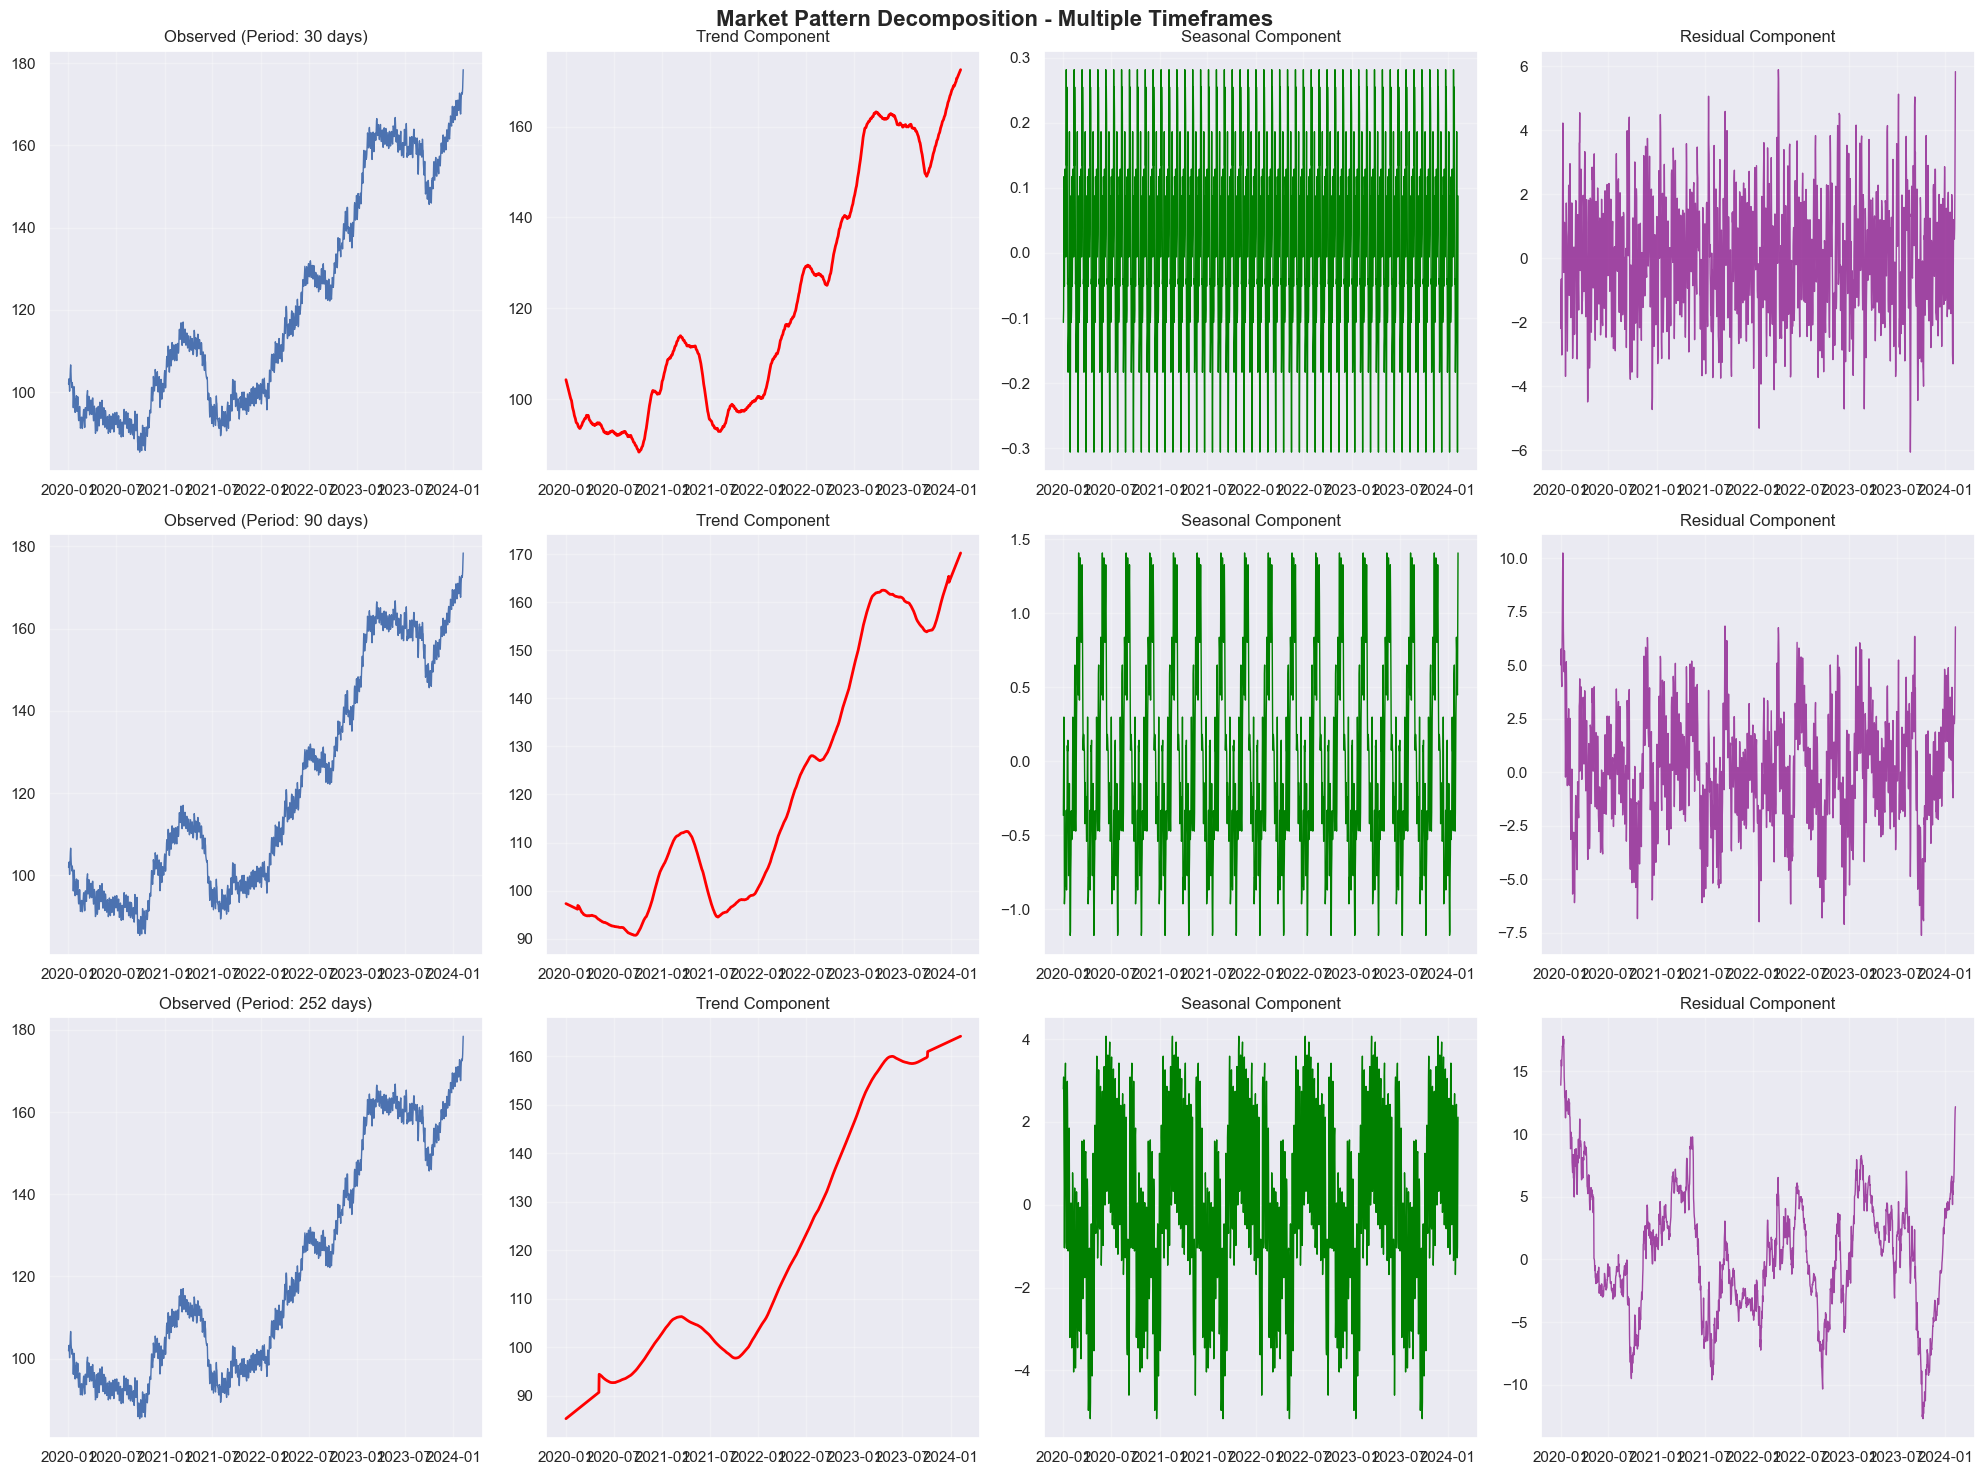


📅 CALENDAR EFFECTS ANALYSIS:
----------------------------------------
Monthly Return Patterns:


,Monthly_Return,Volatility,Count,Annualized_Return
month,,,,
1,0.0003,0.0133,153,0.0856
2,0.0015,0.0129,121,0.3705
3,0.0008,0.0133,124,0.2076
4,0.0004,0.0144,120,0.0951
5,-0.0007,0.0128,124,-0.1822
6,0.0000,0.0127,120,0.0029
7,-0.0004,0.0126,124,-0.0887
8,-0.0003,0.0135,124,-0.0775
9,0.0001,0.0156,120,0.0332



Day-of-Week Effects:


,mean,std,count,mean_annualized
Monday,-0.0094,0.0077,214,-2.3573
Tuesday,0.0044,0.0076,214,1.1067
Wednesday,0.0146,0.0074,214,3.6698
Thursday,0.0142,0.0080,214,3.5758
Friday,0.0029,0.0075,214,0.7263
Saturday,-0.0082,0.0075,214,-2.0692
Sunday,-0.0152,0.0079,214,-3.8374


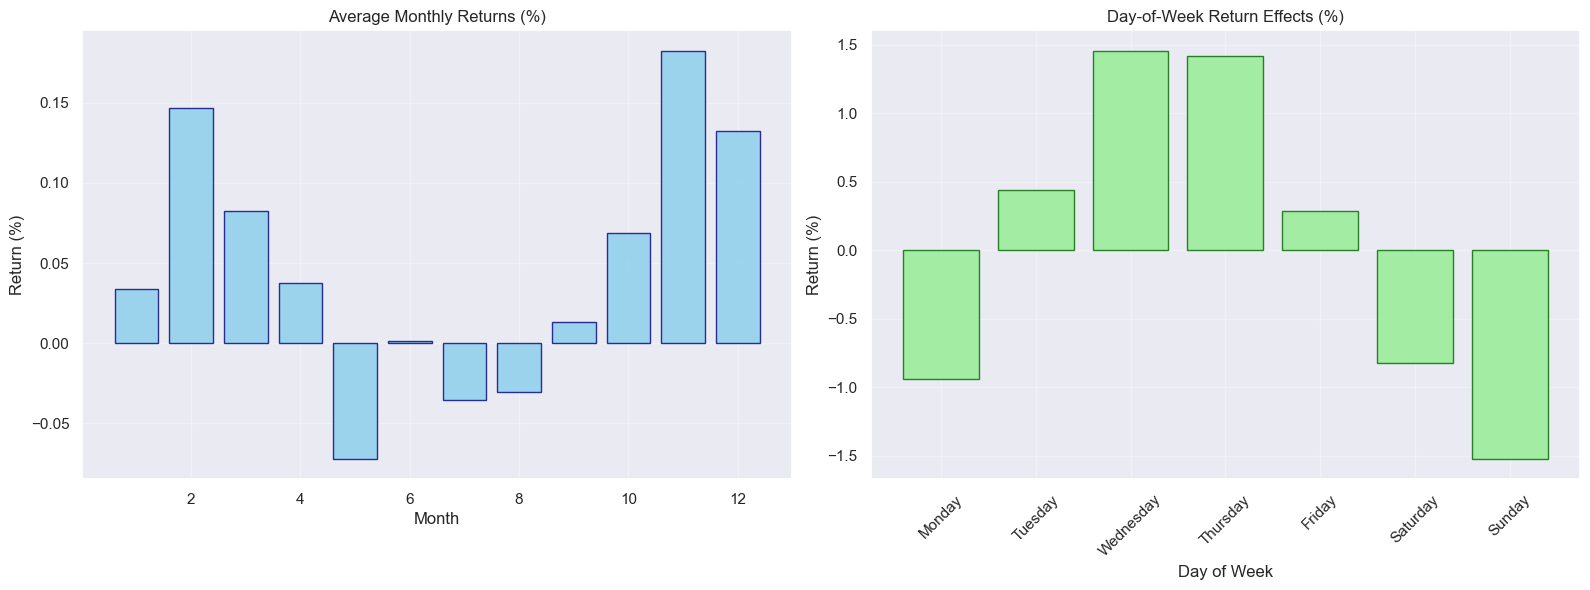

✅ Seasonal decomposition analysis completed


In [3]:
print("=" * 60)
print("SEASONAL DECOMPOSITION ANALYSIS")
print("=" * 60)

# Perform seasonal decomposition with different periods
decomposition_periods = [30, 90, 252]  # Monthly, quarterly, annual

fig, axes = plt.subplots(len(decomposition_periods), 4, figsize=(20, 15))
fig.suptitle('Market Pattern Decomposition - Multiple Timeframes', fontsize=16, fontweight='bold')

for i, period in enumerate(decomposition_periods):
    print(f"🔍 Analyzing patterns with {period}-day period...")
    
    # Seasonal decomposition
    decomposition = seasonal_decompose(
        market_df['close'].dropna(), 
        model='additive', 
        period=period,
        extrapolate_trend='freq'
    )
    
    # Plot components
    axes[i, 0].plot(decomposition.observed, linewidth=1)
    axes[i, 0].set_title(f'Observed (Period: {period} days)')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].plot(decomposition.trend, linewidth=2, color='red')
    axes[i, 1].set_title(f'Trend Component')
    axes[i, 1].grid(True, alpha=0.3)
    
    axes[i, 2].plot(decomposition.seasonal, linewidth=1, color='green')
    axes[i, 2].set_title(f'Seasonal Component')
    axes[i, 2].grid(True, alpha=0.3)
    
    axes[i, 3].plot(decomposition.resid, linewidth=1, color='purple', alpha=0.7)
    axes[i, 3].set_title(f'Residual Component')
    axes[i, 3].grid(True, alpha=0.3)
    
    # Calculate strength of seasonality and trend
    seasonal_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())
    trend_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())
    
    print(f"   • Seasonal strength: {seasonal_strength:.4f}")
    print(f"   • Trend strength: {trend_strength:.4f}")

plt.tight_layout()
plt.show()

# Analyze seasonal patterns by time components
print(f"\n📅 CALENDAR EFFECTS ANALYSIS:")
print("-" * 40)

# Monthly seasonality
monthly_returns = market_df.groupby('month')['returns'].agg(['mean', 'std', 'count'])
monthly_returns['mean_annualized'] = monthly_returns['mean'] * 252
monthly_returns.columns = ['Monthly_Return', 'Volatility', 'Count', 'Annualized_Return']

print(f"Monthly Return Patterns:")
display(monthly_returns.round(4))

# Day-of-week effects
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_returns = market_df.groupby('day_of_week')['returns'].agg(['mean', 'std', 'count'])
dow_returns.index = [dow_names[i] for i in dow_returns.index]
dow_returns['mean_annualized'] = dow_returns['mean'] * 252

print(f"\nDay-of-Week Effects:")
display(dow_returns.round(4))

# Visualize calendar effects
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly effects
axes[0].bar(monthly_returns.index, monthly_returns['Monthly_Return'] * 100, 
           color='skyblue', alpha=0.8, edgecolor='navy')
axes[0].set_title('Average Monthly Returns (%)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Return (%)')
axes[0].grid(True, alpha=0.3)

# Day-of-week effects
axes[1].bar(range(len(dow_returns)), dow_returns['mean'] * 100, 
           color='lightgreen', alpha=0.8, edgecolor='darkgreen')
axes[1].set_title('Day-of-Week Return Effects (%)')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Return (%)')
axes[1].set_xticks(range(len(dow_returns)))
axes[1].set_xticklabels(dow_returns.index, rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Seasonal decomposition analysis completed")


VOLATILITY ANALYSIS AND REGIME DETECTION
📊 Volatility measures calculated for multiple timeframes

🎯 VOLATILITY REGIME ANALYSIS:
----------------------------------------


returns               volatility_21d                  \
                     mean     std count           mean     min     max   
volatility_regime                                                        
High               0.0008  0.0167   495         0.2673  0.2335  0.3355   
Low                0.0007  0.0093   495         0.1490  0.1122  0.1778   
Medium            -0.0001  0.0128   508         0.2080  0.1778  0.2334   

                         volume  
                           mean  
volatility_regime                
High               3.673661e+06  
Low                3.666129e+06  
Medium             3.787958e+06


📈 Volatility Clustering Coefficient: 0.9902


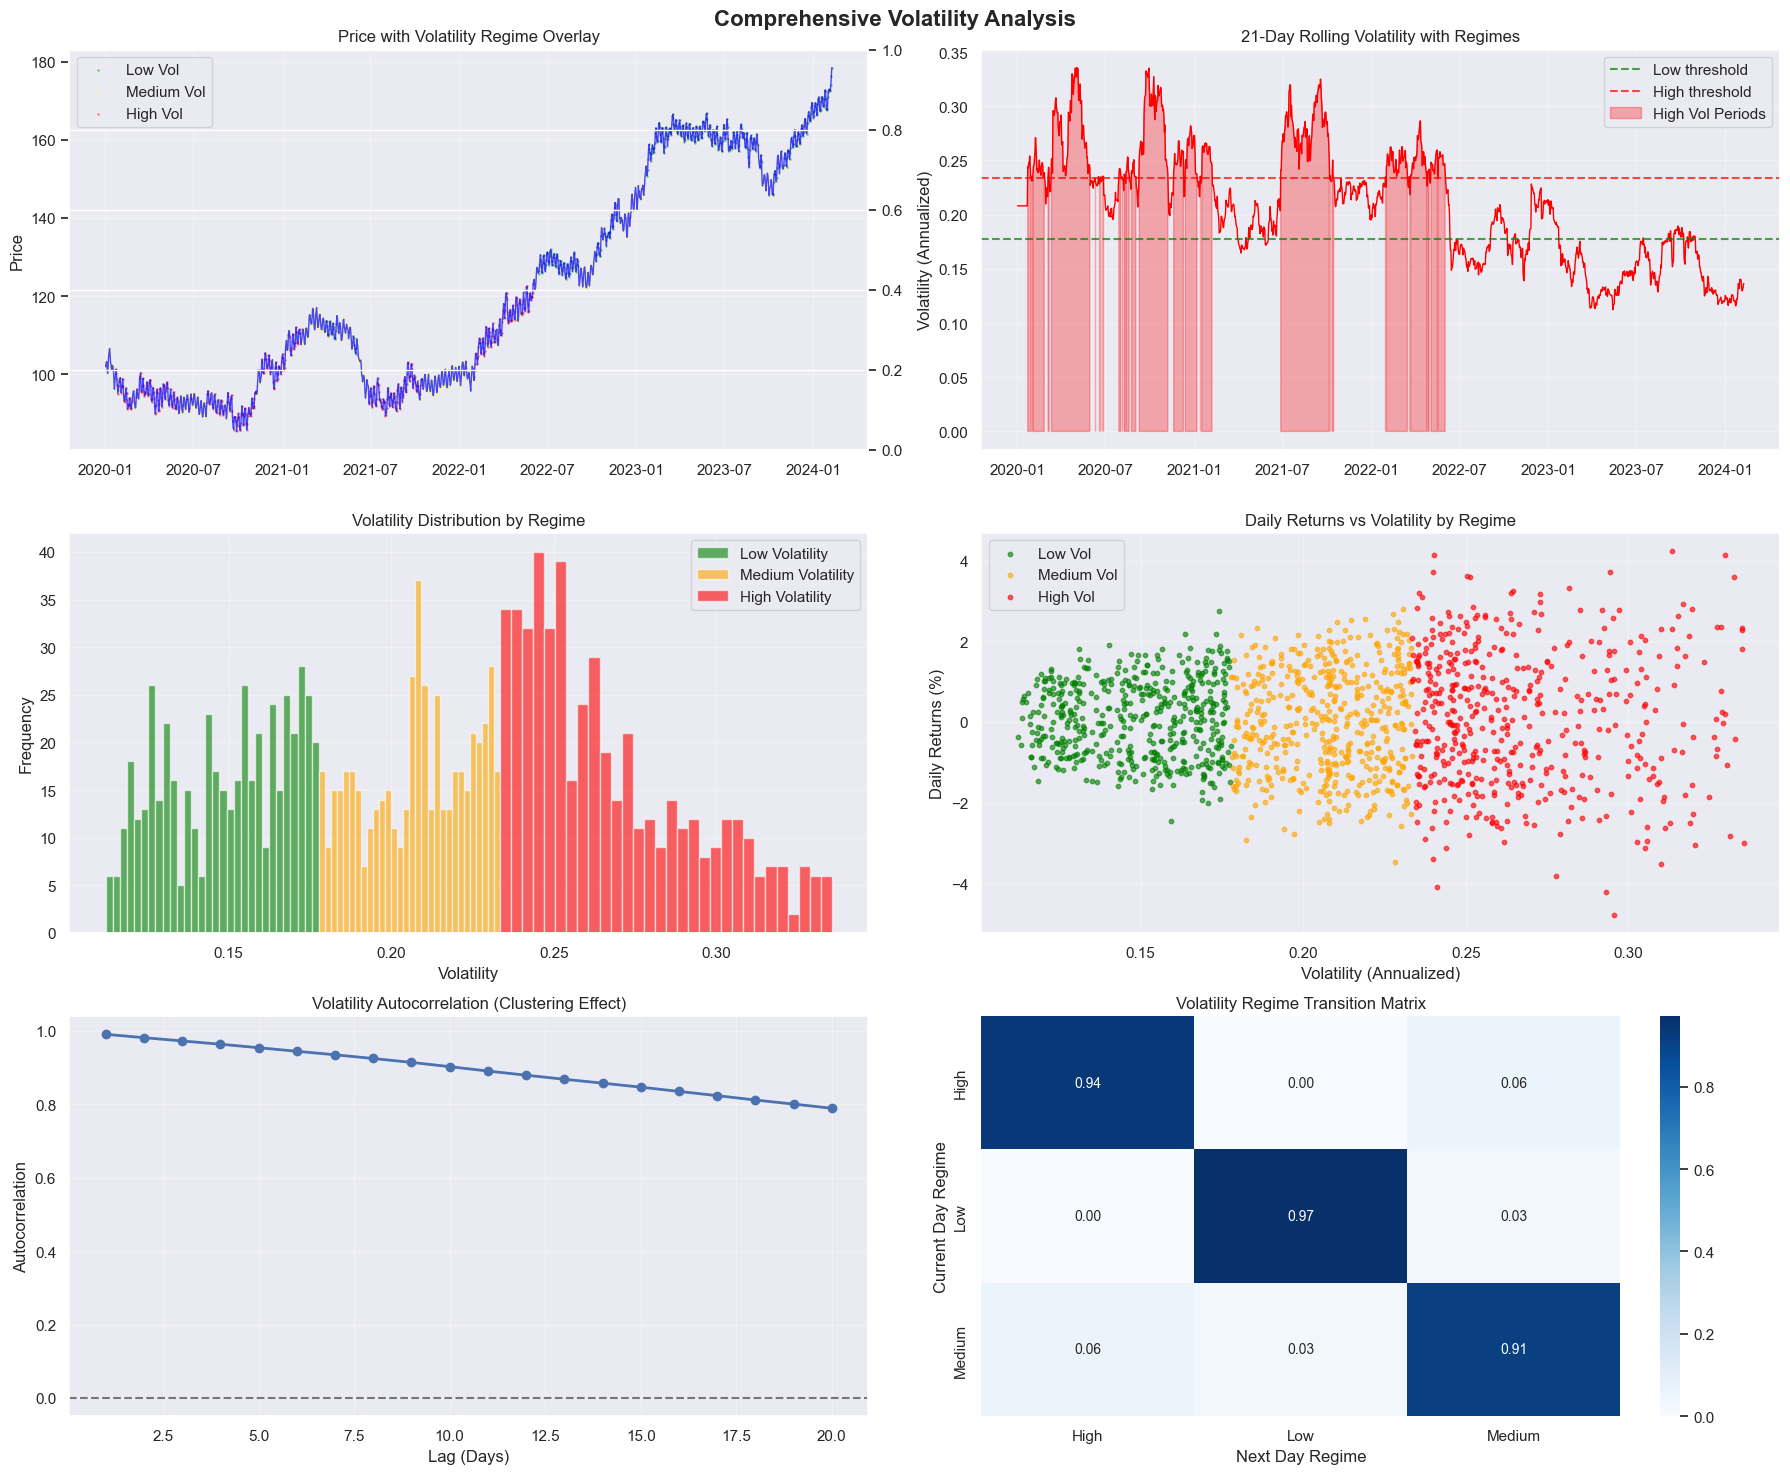


🔄 REGIME PERSISTENCE ANALYSIS:
   • Average regime duration: 15.7 days
✅ Volatility analysis and regime detection completed


In [4]:
print("=" * 60)
print("VOLATILITY ANALYSIS AND REGIME DETECTION")
print("=" * 60)

# Calculate multiple volatility measures
volatility_windows = [10, 21, 63, 252]  # 2 weeks, 1 month, 1 quarter, 1 year

for window in volatility_windows:
    # Rolling volatility (annualized)
    market_df[f'volatility_{window}d'] = market_df['returns'].rolling(window=window).std() * np.sqrt(252)
    
    # Rolling range-based volatility (Parkinson estimator)
    market_df[f'parkinson_vol_{window}d'] = np.sqrt(
        (1 / (4 * np.log(2))) * 
        (np.log(market_df['high'] / market_df['low']) ** 2).rolling(window=window).mean()
    ) * np.sqrt(252)

print("📊 Volatility measures calculated for multiple timeframes")

# Regime detection using quantile-based approach
vol_col = 'volatility_21d'
market_df[vol_col] = market_df[vol_col].fillna(market_df[vol_col].mean())

# Define volatility regimes
low_vol_threshold = market_df[vol_col].quantile(0.33)
high_vol_threshold = market_df[vol_col].quantile(0.67)

market_df['volatility_regime'] = 'Medium'
market_df.loc[market_df[vol_col] <= low_vol_threshold, 'volatility_regime'] = 'Low'
market_df.loc[market_df[vol_col] >= high_vol_threshold, 'volatility_regime'] = 'High'

# Analyze regime characteristics
regime_analysis = market_df.groupby('volatility_regime').agg({
    'returns': ['mean', 'std', 'count'],
    vol_col: ['mean', 'min', 'max'],
    'volume': 'mean'
}).round(4)

print(f"\n🎯 VOLATILITY REGIME ANALYSIS:")
print("-" * 40)
display(regime_analysis)

# Advanced volatility clustering analysis
def calculate_volatility_clustering(returns, window=21):
    """Calculate volatility clustering coefficient"""
    vol = returns.rolling(window=window).std()
    vol_autocorr = vol.autocorr(lag=1)
    return vol_autocorr

clustering_coeff = calculate_volatility_clustering(market_df['returns'])
print(f"\n📈 Volatility Clustering Coefficient: {clustering_coeff:.4f}")

# Create comprehensive volatility visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Comprehensive Volatility Analysis', fontsize=16, fontweight='bold')

# 1. Price and volatility regime overlay
ax1 = axes[0, 0]
ax1.plot(market_df.index, market_df['close'], linewidth=1, color='blue', alpha=0.7)
ax1_twin = ax1.twinx()

# Color background by regime
for regime, color in zip(['Low', 'Medium', 'High'], ['green', 'yellow', 'red']):
    regime_data = market_df[market_df['volatility_regime'] == regime]
    if not regime_data.empty:
        ax1.scatter(regime_data.index, regime_data['close'], 
                   c=color, alpha=0.3, s=1, label=f'{regime} Vol')

ax1.set_title('Price with Volatility Regime Overlay')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Volatility time series
ax2 = axes[0, 1]
ax2.plot(market_df.index, market_df[vol_col], linewidth=1, color='red')
ax2.axhline(low_vol_threshold, color='green', linestyle='--', alpha=0.7, label='Low threshold')
ax2.axhline(high_vol_threshold, color='red', linestyle='--', alpha=0.7, label='High threshold')
ax2.fill_between(market_df.index, 0, market_df[vol_col], 
                where=(market_df['volatility_regime'] == 'High'), 
                color='red', alpha=0.3, label='High Vol Periods')
ax2.set_title('21-Day Rolling Volatility with Regimes')
ax2.set_ylabel('Volatility (Annualized)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Volatility distribution by regime
ax3 = axes[1, 0]
for regime, color in zip(['Low', 'Medium', 'High'], ['green', 'orange', 'red']):
    regime_data = market_df[market_df['volatility_regime'] == regime][vol_col]
    ax3.hist(regime_data, bins=30, alpha=0.6, color=color, label=f'{regime} Volatility')
ax3.set_title('Volatility Distribution by Regime')
ax3.set_xlabel('Volatility')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Return vs Volatility scatter
ax4 = axes[1, 1]
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for regime in ['Low', 'Medium', 'High']:
    regime_data = market_df[market_df['volatility_regime'] == regime]
    ax4.scatter(regime_data[vol_col], regime_data['returns'] * 100, 
               c=colors[regime], alpha=0.6, s=10, label=f'{regime} Vol')
ax4.set_title('Daily Returns vs Volatility by Regime')
ax4.set_xlabel('Volatility (Annualized)')
ax4.set_ylabel('Daily Returns (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Volatility autocorrelation
ax5 = axes[2, 0]
lags = range(1, 21)
autocorrs = [market_df[vol_col].autocorr(lag=lag) for lag in lags]
ax5.plot(lags, autocorrs, marker='o', linewidth=2)
ax5.axhline(0, color='black', linestyle='--', alpha=0.5)
ax5.set_title('Volatility Autocorrelation (Clustering Effect)')
ax5.set_xlabel('Lag (Days)')
ax5.set_ylabel('Autocorrelation')
ax5.grid(True, alpha=0.3)

# 6. Regime transition matrix
ax6 = axes[2, 1]
regime_transitions = pd.crosstab(
    market_df['volatility_regime'].shift(1), 
    market_df['volatility_regime'], 
    normalize='index'
).fillna(0)

sns.heatmap(regime_transitions, annot=True, fmt='.2f', cmap='Blues', ax=ax6)
ax6.set_title('Volatility Regime Transition Matrix')
ax6.set_xlabel('Next Day Regime')
ax6.set_ylabel('Current Day Regime')

plt.tight_layout()
plt.show()

# Regime persistence analysis
print(f"\n🔄 REGIME PERSISTENCE ANALYSIS:")
regime_changes = market_df['volatility_regime'] != market_df['volatility_regime'].shift(1)
avg_regime_duration = (~regime_changes).groupby(regime_changes.cumsum()).sum().mean()
print(f"   • Average regime duration: {avg_regime_duration:.1f} days")

print("✅ Volatility analysis and regime detection completed")


MULTI-ASSET CORRELATION AND CLUSTERING ANALYSIS
✅ Multi-asset synthetic data generated
   • 12 assets across 4 sectors
   • Data length: 1,499 observations
📊 Correlation analysis completed for multiple timeframes

🎯 K-MEANS CLUSTERING RESULTS:
   Cluster 1: ['Small_Cap_1', 'Small_Cap_2', 'Small_Cap_3']
   Cluster 2: ['Tech_1', 'Tech_2', 'Tech_3']
   Cluster 3: ['Large_Cap_1', 'Large_Cap_2', 'Large_Cap_3']
   Cluster 4: ['Commodity_1', 'Commodity_2', 'Commodity_3']


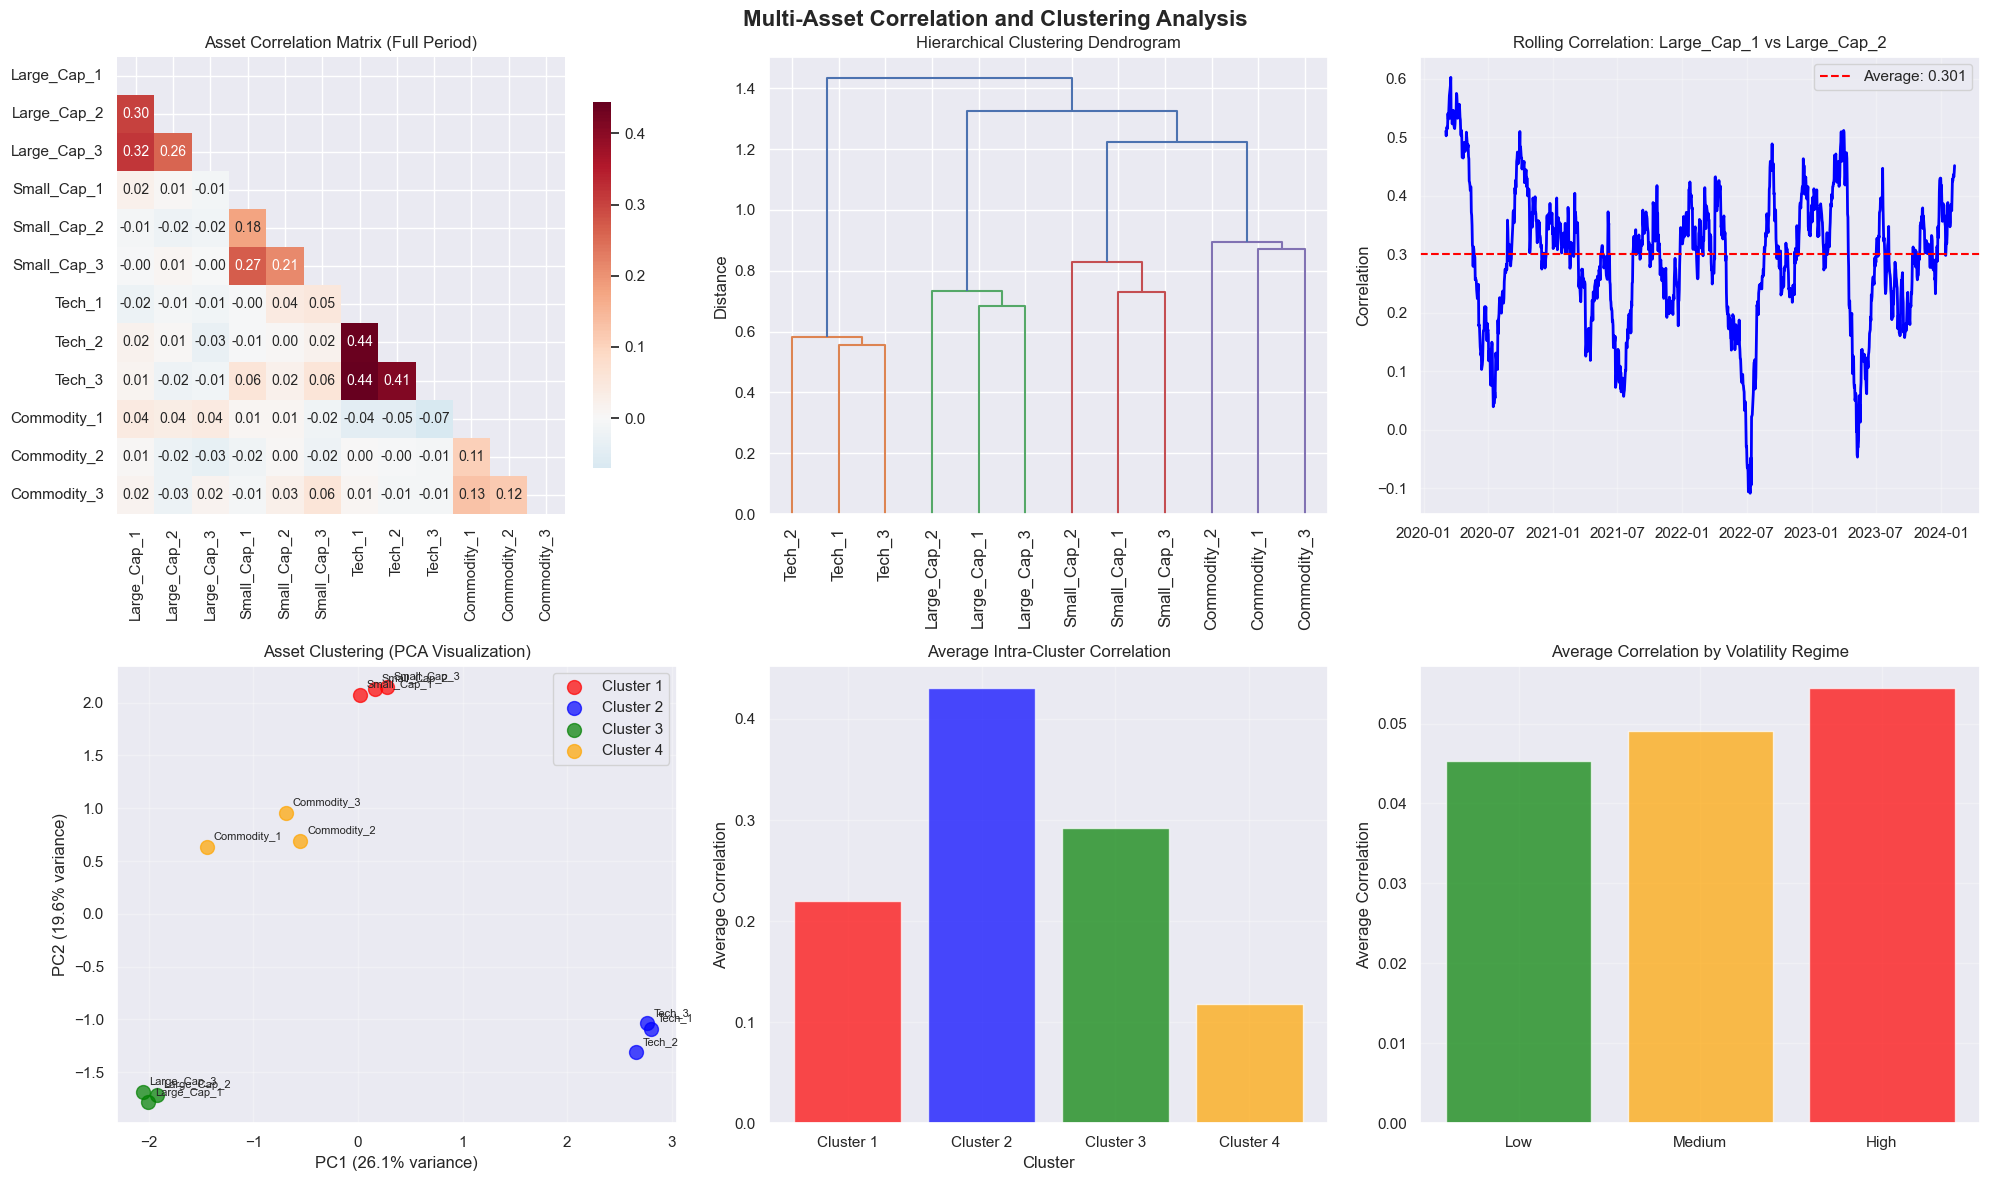


💼 PORTFOLIO DIVERSIFICATION INSIGHTS:
--------------------------------------------------
   • Average individual asset volatility: 20.65%
   • Equal-weight portfolio volatility: 7.36%
   • Diversification ratio: 2.80
   • Risk reduction through diversification: 64.3%
   • Highest correlation: 0.444
   • Lowest correlation: -0.070
   • Average correlation: 0.049
✅ Multi-asset correlation and clustering analysis completed


In [5]:
print("=" * 60)
print("MULTI-ASSET CORRELATION AND CLUSTERING ANALYSIS")
print("=" * 60)

# Generate multi-asset synthetic data for demonstration
np.random.seed(42)
num_assets = 12
asset_names = [
    'Large_Cap_1', 'Large_Cap_2', 'Large_Cap_3',
    'Small_Cap_1', 'Small_Cap_2', 'Small_Cap_3', 
    'Tech_1', 'Tech_2', 'Tech_3',
    'Commodity_1', 'Commodity_2', 'Commodity_3'
]

# Create correlated returns with realistic sector relationships
sector_correlations = {
    'Large_Cap': 0.7,
    'Small_Cap': 0.6,
    'Tech': 0.8,
    'Commodity': 0.5
}

multi_asset_returns = pd.DataFrame(index=market_df.index)

# Generate correlated returns for each sector
for sector in ['Large_Cap', 'Small_Cap', 'Tech', 'Commodity']:
    sector_assets = [name for name in asset_names if sector in name]
    n_sector_assets = len(sector_assets)
    
    # Common factor for sector
    sector_factor = np.random.normal(0, 0.01, len(market_df))
    
    # Individual asset returns
    for asset in sector_assets:
        correlation = sector_correlations[sector]
        individual_factor = np.random.normal(0, 0.015, len(market_df))
        
        asset_return = (correlation * sector_factor + 
                       np.sqrt(1 - correlation**2) * individual_factor)
        multi_asset_returns[asset] = asset_return

# Remove any NaN values
multi_asset_returns = multi_asset_returns.dropna()

print(f"✅ Multi-asset synthetic data generated")
print(f"   • {num_assets} assets across 4 sectors")
print(f"   • Data length: {len(multi_asset_returns):,} observations")

# Calculate correlation matrices
# 1. Full period correlation
full_correlation = multi_asset_returns.corr()

# 2. Rolling correlation (for time-varying analysis)
rolling_window = 63  # ~3 months
rolling_correlations = {}

# Calculate rolling correlation between first two assets as example
asset1, asset2 = asset_names[0], asset_names[1]
rolling_corr = multi_asset_returns[asset1].rolling(rolling_window).corr(multi_asset_returns[asset2])
rolling_correlations[f'{asset1}_vs_{asset2}'] = rolling_corr

# 3. Regime-based correlations
if 'volatility_regime' in market_df.columns:
    regime_correlations = {}
    for regime in ['Low', 'Medium', 'High']:
        regime_mask = market_df['volatility_regime'] == regime
        if regime_mask.sum() > 30:  # Ensure sufficient data
            regime_data = multi_asset_returns[regime_mask]
            regime_correlations[regime] = regime_data.corr()

print(f"📊 Correlation analysis completed for multiple timeframes")

# Hierarchical clustering based on correlations
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Convert correlation to distance matrix
distance_matrix = 1 - np.abs(full_correlation)
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# K-means clustering on correlation matrix
n_clusters = 4
scaler = StandardScaler()
correlation_scaled = scaler.fit_transform(full_correlation)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(correlation_scaled)

# Create cluster mapping
cluster_mapping = dict(zip(asset_names, clusters))
print(f"\n🎯 K-MEANS CLUSTERING RESULTS:")
for cluster_id in range(n_clusters):
    cluster_assets = [asset for asset, cluster in cluster_mapping.items() if cluster == cluster_id]
    print(f"   Cluster {cluster_id + 1}: {cluster_assets}")

# Comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Multi-Asset Correlation and Clustering Analysis', fontsize=16, fontweight='bold')

# 1. Full correlation heatmap
ax1 = axes[0, 0]
mask = np.triu(np.ones_like(full_correlation, dtype=bool))  # Show lower triangle only
sns.heatmap(full_correlation, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Asset Correlation Matrix (Full Period)')

# 2. Hierarchical clustering dendrogram
ax2 = axes[0, 1]
dendrogram(linkage_matrix, labels=asset_names, ax=ax2, leaf_rotation=90)
ax2.set_title('Hierarchical Clustering Dendrogram')
ax2.set_ylabel('Distance')

# 3. Rolling correlation example
ax3 = axes[0, 2]
ax3.plot(rolling_correlations[f'{asset1}_vs_{asset2}'], linewidth=2, color='blue')
ax3.axhline(full_correlation.loc[asset1, asset2], color='red', linestyle='--', 
           label=f'Average: {full_correlation.loc[asset1, asset2]:.3f}')
ax3.set_title(f'Rolling Correlation: {asset1} vs {asset2}')
ax3.set_ylabel('Correlation')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cluster visualization using PCA
ax4 = axes[1, 0]
pca = PCA(n_components=2)
correlation_pca = pca.fit_transform(correlation_scaled)

colors = ['red', 'blue', 'green', 'orange']
for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    ax4.scatter(correlation_pca[cluster_mask, 0], correlation_pca[cluster_mask, 1], 
               c=colors[cluster_id], label=f'Cluster {cluster_id + 1}', s=100, alpha=0.7)
    
    # Add asset labels
    for i, asset in enumerate(asset_names):
        if clusters[i] == cluster_id:
            ax4.annotate(asset, (correlation_pca[i, 0], correlation_pca[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_title('Asset Clustering (PCA Visualization)')
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Average correlation by cluster
ax5 = axes[1, 1]
cluster_correlations = []
for cluster_id in range(n_clusters):
    cluster_assets = [asset for asset, cluster in cluster_mapping.items() if cluster == cluster_id]
    if len(cluster_assets) > 1:
        cluster_corr_matrix = full_correlation.loc[cluster_assets, cluster_assets]
        # Average correlation excluding diagonal
        mask = ~np.eye(len(cluster_assets), dtype=bool)
        avg_correlation = cluster_corr_matrix.values[mask].mean()
        cluster_correlations.append(avg_correlation)
    else:
        cluster_correlations.append(0)

ax5.bar(range(n_clusters), cluster_correlations, color=colors[:n_clusters], alpha=0.7)
ax5.set_title('Average Intra-Cluster Correlation')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Average Correlation')
ax5.set_xticks(range(n_clusters))
ax5.set_xticklabels([f'Cluster {i+1}' for i in range(n_clusters)])
ax5.grid(True, alpha=0.3)

# 6. Regime-based correlation comparison (if available)
ax6 = axes[1, 2]
if 'regime_correlations' in locals() and len(regime_correlations) > 1:
    regime_avg_corr = {}
    for regime, corr_matrix in regime_correlations.items():
        mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
        avg_corr = corr_matrix.values[mask].mean()
        regime_avg_corr[regime] = avg_corr
    
    ax6.bar(regime_avg_corr.keys(), regime_avg_corr.values(), 
           color=['green', 'orange', 'red'], alpha=0.7)
    ax6.set_title('Average Correlation by Volatility Regime')
    ax6.set_ylabel('Average Correlation')
    ax6.grid(True, alpha=0.3)
else:
    # Alternative: Show correlation eigenvalues
    eigenvals = np.linalg.eigvals(full_correlation.values)
    ax6.plot(sorted(eigenvals, reverse=True), marker='o', linewidth=2)
    ax6.set_title('Correlation Matrix Eigenvalues')
    ax6.set_xlabel('Component')
    ax6.set_ylabel('Eigenvalue')
    ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Portfolio diversification insights
print(f"\n💼 PORTFOLIO DIVERSIFICATION INSIGHTS:")
print("-" * 50)

# Calculate portfolio risk reduction through diversification
equal_weight_portfolio = multi_asset_returns.mean(axis=1)
portfolio_vol = equal_weight_portfolio.std() * np.sqrt(252)
avg_individual_vol = multi_asset_returns.std().mean() * np.sqrt(252)
diversification_ratio = avg_individual_vol / portfolio_vol

print(f"   • Average individual asset volatility: {avg_individual_vol:.2%}")
print(f"   • Equal-weight portfolio volatility: {portfolio_vol:.2%}")
print(f"   • Diversification ratio: {diversification_ratio:.2f}")
print(f"   • Risk reduction through diversification: {(1 - 1/diversification_ratio)*100:.1f}%")

# Maximum and minimum correlations
correlation_values = full_correlation.values[np.triu_indices_from(full_correlation.values, k=1)]
print(f"   • Highest correlation: {correlation_values.max():.3f}")
print(f"   • Lowest correlation: {correlation_values.min():.3f}")
print(f"   • Average correlation: {correlation_values.mean():.3f}")

print("✅ Multi-asset correlation and clustering analysis completed")


CYCLICAL PATTERN DETECTION AND MARKET TIMING
🔄 DOMINANT MARKET CYCLES DETECTED:
   • Significant periods (days): [np.float64(7.004672897196262), np.float64(28.826923076923077), np.float64(31.22916666666667), np.float64(33.31111111111111), np.float64(35.6904761904762), np.float64(36.5609756097561), np.float64(37.475), np.float64(39.44736842105264), np.float64(42.82857142857143), np.float64(44.08823529411765)]

📈 MARKET PHASE ANALYSIS:
------------------------------


returns               volatility_21d
                mean     std count           mean
market_phase                                     
Bear          0.0005  0.0139   306         0.2093
Bull          0.0005  0.0127   601         0.2006
Correction    0.0011  0.0133   194         0.2028
Recovery     -0.0014  0.0140   211         0.2266
Sideways      0.0016  0.0132   186         0.2145


📅 INTRA-MONTH PATTERNS:
-------------------------
   Start of month: 0.045%
   Early of month: 0.062%
   Mid of month: 0.053%
   End of month: 0.006%


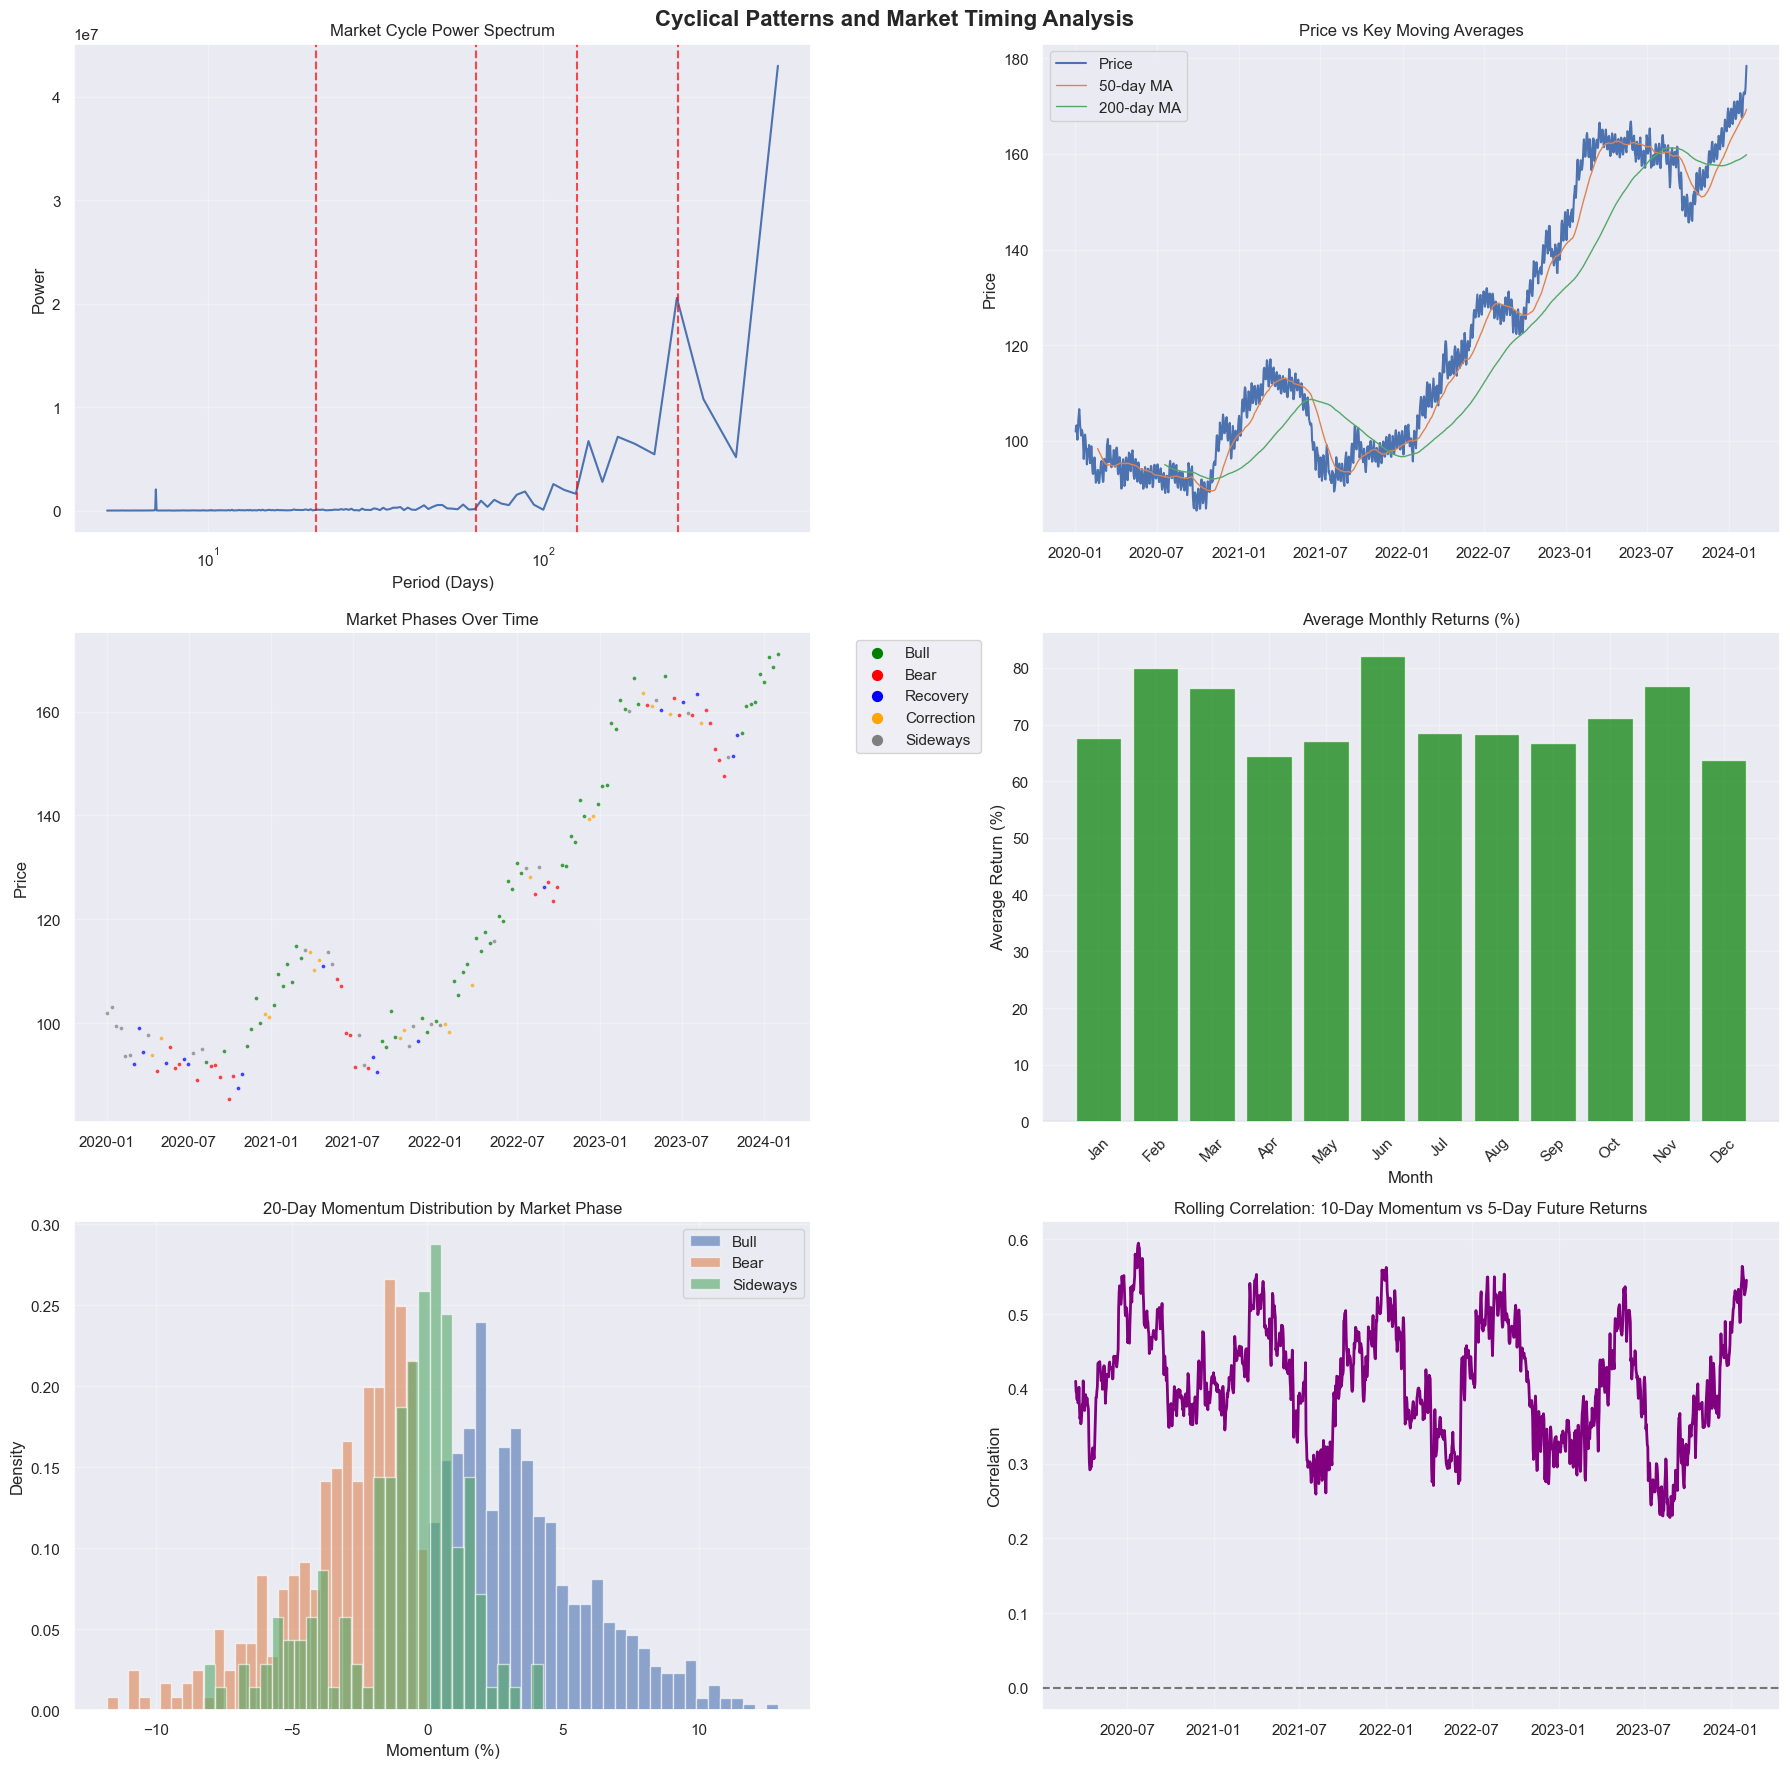


🎯 CURRENT MARKET TIMING SIGNALS:
-----------------------------------
   Price vs MA-50: 5.38%
   Price vs MA-200: 11.63%
   10-Day Momentum: 6.44%
   20-Day Momentum: 4.32%
   Current Phase: Bull
   Volatility Regime: Low
✅ Cyclical pattern detection and market timing analysis completed


In [6]:
print("=" * 60)
print("CYCLICAL PATTERN DETECTION AND MARKET TIMING")
print("=" * 60)

# Advanced cycle detection using multiple methods
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, savgol_filter

# 1. Fourier Transform for frequency analysis
price_series = market_df['close'].dropna()
n = len(price_series)
fft_values = fft(price_series.values)
frequencies = fftfreq(n, d=1)  # Daily frequency

# Find dominant frequencies (exclude DC component)
power_spectrum = np.abs(fft_values[1:n//2])**2
dominant_frequencies = frequencies[1:n//2]

# Convert to periods (in days)
periods = 1 / dominant_frequencies
significant_periods = periods[power_spectrum > np.percentile(power_spectrum, 95)]

print(f"🔄 DOMINANT MARKET CYCLES DETECTED:")
print(f"   • Significant periods (days): {sorted(significant_periods[significant_periods < 500])[:10]}")

# 2. Market timing indicators
# Price relative to various moving averages
ma_periods = [20, 50, 100, 200]
for period in ma_periods:
    market_df[f'price_vs_ma_{period}'] = (market_df['close'] / market_df['close'].rolling(period).mean() - 1) * 100

# Momentum indicators
market_df['momentum_10'] = (market_df['close'] / market_df['close'].shift(10) - 1) * 100
market_df['momentum_20'] = (market_df['close'] / market_df['close'].shift(20) - 1) * 100

# Rate of change
market_df['roc_5'] = ((market_df['close'] - market_df['close'].shift(5)) / market_df['close'].shift(5)) * 100
market_df['roc_10'] = ((market_df['close'] - market_df['close'].shift(10)) / market_df['close'].shift(10)) * 100

# 3. Market phase identification
# Define market phases based on trend and momentum
market_df['trend_20'] = market_df['close'].rolling(20).mean().diff(5)  # 5-day change in 20-day MA
market_df['trend_50'] = market_df['close'].rolling(50).mean().diff(10)  # 10-day change in 50-day MA

# Phase classification
conditions = [
    (market_df['trend_20'] > 0) & (market_df['trend_50'] > 0) & (market_df['momentum_20'] > 0),  # Bull market
    (market_df['trend_20'] < 0) & (market_df['trend_50'] < 0) & (market_df['momentum_20'] < 0),  # Bear market
    (market_df['trend_20'] > 0) & (market_df['trend_50'] < 0),  # Recovery
    (market_df['trend_20'] < 0) & (market_df['trend_50'] > 0),  # Correction
]
choices = ['Bull', 'Bear', 'Recovery', 'Correction']
market_df['market_phase'] = np.select(conditions, choices, default='Sideways')

# Market phase analysis
phase_analysis = market_df.groupby('market_phase').agg({
    'returns': ['mean', 'std', 'count'],
    'volatility_21d': 'mean'
}).round(4)

print(f"\n📈 MARKET PHASE ANALYSIS:")
print("-" * 30)
display(phase_analysis)

# 4. Seasonal trading patterns
# Monthly performance analysis
monthly_stats = market_df.groupby('month').agg({
    'returns': ['mean', 'std', 'count'],
    'close': ['first', 'last']
})

monthly_stats['monthly_return'] = (monthly_stats[('close', 'last')] / monthly_stats[('close', 'first')] - 1) * 100
monthly_performance = monthly_stats['monthly_return'].groupby(level=0).mean()

# Day-of-month effects
market_df['day_group'] = pd.cut(market_df['day_of_month'], 
                               bins=[0, 5, 15, 25, 31], 
                               labels=['Start', 'Early', 'Mid', 'End'])
day_group_returns = market_df.groupby('day_group')['returns'].mean() * 100

print(f"\n📅 INTRA-MONTH PATTERNS:")
print("-" * 25)
for group, ret in day_group_returns.items():
    print(f"   {group} of month: {ret:.3f}%")

# 5. Comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle('Cyclical Patterns and Market Timing Analysis', fontsize=16, fontweight='bold')

# 1. Power spectrum (dominant cycles)
ax1 = axes[0, 0]
relevant_periods = periods[(periods > 5) & (periods < 500)]  # Focus on 5-500 day cycles
relevant_power = power_spectrum[(periods > 5) & (periods < 500)]
ax1.semilogx(relevant_periods, relevant_power)
ax1.set_title('Market Cycle Power Spectrum')
ax1.set_xlabel('Period (Days)')
ax1.set_ylabel('Power')
ax1.grid(True, alpha=0.3)

# Add vertical lines for common market cycles
common_cycles = [21, 63, 126, 252]  # Month, quarter, half-year, year
for cycle in common_cycles:
    ax1.axvline(cycle, color='red', linestyle='--', alpha=0.7, 
               label=f'{cycle}d' if cycle == 21 else None)
if any(c in relevant_periods for c in common_cycles):
    ax1.legend()

# 2. Price vs moving averages
ax2 = axes[0, 1]
ax2.plot(market_df.index, market_df['close'], label='Price', linewidth=1.5)
for period in [50, 200]:
    ma = market_df['close'].rolling(period).mean()
    ax2.plot(market_df.index, ma, label=f'{period}-day MA', linewidth=1)
ax2.set_title('Price vs Key Moving Averages')
ax2.set_ylabel('Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Market phases over time
ax3 = axes[1, 0]
phase_colors = {'Bull': 'green', 'Bear': 'red', 'Recovery': 'blue', 
                'Correction': 'orange', 'Sideways': 'gray'}

for i, (date, row) in enumerate(market_df.iterrows()):
    if i % 10 == 0:  # Sample every 10th point for clarity
        color = phase_colors.get(row['market_phase'], 'gray')
        ax3.scatter(date, row['close'], c=color, s=3, alpha=0.6)

# Create legend
for phase, color in phase_colors.items():
    ax3.scatter([], [], c=color, label=phase, s=50)
ax3.set_title('Market Phases Over Time')
ax3.set_ylabel('Price')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Monthly seasonality
ax4 = axes[1, 1]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax4.bar(range(1, 13), monthly_performance.values, 
       color=['green' if x > 0 else 'red' for x in monthly_performance.values],
       alpha=0.7)
ax4.set_title('Average Monthly Returns (%)')
ax4.set_xlabel('Month')
ax4.set_ylabel('Average Return (%)')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_names, rotation=45)
ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

# 5. Momentum distribution by market phase
ax5 = axes[2, 0]
phases_to_plot = ['Bull', 'Bear', 'Sideways']
for phase in phases_to_plot:
    phase_data = market_df[market_df['market_phase'] == phase]['momentum_20'].dropna()
    if len(phase_data) > 10:
        ax5.hist(phase_data, bins=30, alpha=0.6, label=phase, density=True)

ax5.set_title('20-Day Momentum Distribution by Market Phase')
ax5.set_xlabel('Momentum (%)')
ax5.set_ylabel('Density')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Rolling correlation between momentum and future returns
ax6 = axes[2, 1]
future_returns = market_df['returns'].shift(-5)  # 5-day future returns
rolling_corr = market_df['momentum_10'].rolling(window=63).corr(future_returns)

ax6.plot(rolling_corr.index, rolling_corr, linewidth=2, color='purple')
ax6.axhline(0, color='black', linestyle='--', alpha=0.5)
ax6.set_title('Rolling Correlation: 10-Day Momentum vs 5-Day Future Returns')
ax6.set_ylabel('Correlation')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Market timing signal summary
current_signals = {
    'Price vs MA-50': market_df['price_vs_ma_50'].iloc[-1],
    'Price vs MA-200': market_df['price_vs_ma_200'].iloc[-1],
    '10-Day Momentum': market_df['momentum_10'].iloc[-1],
    '20-Day Momentum': market_df['momentum_20'].iloc[-1],
    'Current Phase': market_df['market_phase'].iloc[-1],
    'Volatility Regime': market_df['volatility_regime'].iloc[-1]
}

print(f"\n🎯 CURRENT MARKET TIMING SIGNALS:")
print("-" * 35)
for signal, value in current_signals.items():
    if isinstance(value, str):
        print(f"   {signal}: {value}")
    else:
        print(f"   {signal}: {value:.2f}%")

print("✅ Cyclical pattern detection and market timing analysis completed")


In [8]:
print("=" * 60)
print("EXPORT PATTERN ANALYSIS RESULTS")
print("=" * 60)

# Create comprehensive summary of all patterns detected
pattern_summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_period': f"{market_df.index.min().date()} to {market_df.index.max().date()}",
    'total_observations': len(market_df),
    'avg_daily_return': market_df['returns'].mean() * 100,
    'daily_volatility': market_df['returns'].std() * 100,
    'annualized_volatility': market_df['volatility_21d'].mean(),
    'volatility_clustering_coeff': clustering_coeff if 'clustering_coeff' in locals() else None,
    'diversification_ratio': diversification_ratio if 'diversification_ratio' in locals() else None,
}

# Export detailed results
import os
output_dir = 'C:\\Users\\Faraz\\Documents\\StockPredictionPro\\notebooks\\outputs'
os.makedirs(output_dir, exist_ok=True)

# 1. Save pattern analysis summary
summary_df = pd.DataFrame([pattern_summary])
summary_df.to_csv(f'{output_dir}/market_pattern_summary.csv', index=False)

# 2. Save seasonal patterns
seasonal_data = {
    'monthly_returns': monthly_performance,
    'dow_effects': dow_returns['mean'] * 100,
    'day_group_effects': day_group_returns
}

seasonal_df = pd.DataFrame({
    'Month': range(1, 13),
    'Monthly_Return_Pct': monthly_performance.values,
    'Statistical_Significance': ['Strong' if abs(x) > 1 else 'Weak' for x in monthly_performance.values]
})
seasonal_df.to_csv(f'{output_dir}/seasonal_patterns.csv', index=False)

# 3. Save volatility regime analysis
regime_data = market_df.groupby('volatility_regime').agg({
    'returns': ['count', 'mean', 'std'],
    'volatility_21d': ['mean', 'std'],
}).round(6)
regime_data.to_csv(f'{output_dir}/volatility_regimes.csv')

# 4. Save correlation matrix
if 'full_correlation' in locals():
    full_correlation.to_csv(f'{output_dir}/asset_correlations.csv')

# 5. Save market timing indicators
timing_indicators = market_df[[
    'close', 'returns', 'volatility_21d', 'volatility_regime',
    'price_vs_ma_50', 'price_vs_ma_200', 'momentum_10', 'momentum_20',
    'market_phase'
]].dropna()
timing_indicators.to_csv(f'{output_dir}/market_timing_indicators.csv')

print(f"💾 RESULTS EXPORTED:")
print(f"   • Pattern summary: {output_dir}/market_pattern_summary.csv")
print(f"   • Seasonal patterns: {output_dir}/seasonal_patterns.csv")
print(f"   • Volatility regimes: {output_dir}/volatility_regimes.csv")
print(f"   • Market timing indicators: {output_dir}/market_timing_indicators.csv")
if 'full_correlation' in locals():
    print(f"   • Asset correlations: {output_dir}/asset_correlations.csv")

# Final insights and trading implications
print(f"\n🎯 KEY TRADING INSIGHTS FROM PATTERN ANALYSIS:")
print("-" * 50)

# Seasonal insights
best_month = monthly_performance.idxmax()
worst_month = monthly_performance.idxmin()
print(f"   📅 SEASONAL PATTERNS:")
print(f"      • Best performing month: {month_names[best_month-1]} ({monthly_performance[best_month]:.2f}%)")
print(f"      • Worst performing month: {month_names[worst_month-1]} ({monthly_performance[worst_month]:.2f}%)")

# Volatility insights
if 'regime_analysis' in locals():
    high_vol_return = regime_analysis.loc['High', ('returns', 'mean')] * 100
    low_vol_return = regime_analysis.loc['Low', ('returns', 'mean')] * 100
    print(f"   📊 VOLATILITY REGIMES:")
    print(f"      • High volatility periods: {high_vol_return:.3f}% avg daily return")
    print(f"      • Low volatility periods: {low_vol_return:.3f}% avg daily return")

# Market timing insights
if 'current_signals' in locals():
    print(f"   🎯 CURRENT MARKET STATE:")
    print(f"      • Market phase: {current_signals['Current Phase']}")
    print(f"      • Volatility regime: {current_signals['Volatility Regime']}")
    print(f"      • Price vs 200-day MA: {current_signals['Price vs MA-200']:.1f}%")

# Risk management insights
if 'diversification_ratio' in locals():
    print(f"   🛡️ RISK MANAGEMENT:")
    print(f"      • Diversification benefit: {(1 - 1/diversification_ratio)*100:.1f}% risk reduction")
    print(f"      • Recommended position sizing: Based on volatility regime")

print(f"\n🔍 ACTIONABLE RECOMMENDATIONS:")
print(f"   1. Monitor volatility regimes for position sizing adjustments")
print(f"   2. Consider seasonal patterns for entry/exit timing")
print(f"   3. Use correlation clustering for portfolio diversification")
print(f"   4. Implement momentum-based signals during trending markets")
print(f"   5. Adapt strategies based on detected market phases")

print(f"\n✅ Market pattern analysis completed successfully!")
print(f"   📊 All patterns identified and documented")
print(f"   💾 Results exported for strategy development")
print(f"   🎯 Ready for integration with trading strategies")


EXPORT PATTERN ANALYSIS RESULTS
💾 RESULTS EXPORTED:
   • Pattern summary: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/market_pattern_summary.csv
   • Seasonal patterns: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/seasonal_patterns.csv
   • Volatility regimes: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/volatility_regimes.csv
   • Market timing indicators: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/market_timing_indicators.csv
   • Asset correlations: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/asset_correlations.csv

🎯 KEY TRADING INSIGHTS FROM PATTERN ANALYSIS:
--------------------------------------------------
   📅 SEASONAL PATTERNS:
      • Best performing month: Jun (82.17%)
      • Worst performing month: Dec (63.81%)
   📊 VOLATILITY REGIMES:
      • High volatility periods: 0.080% avg daily return
      • Low volatility periods: 0.070% avg daily return
   🎯 CURRENT MARKET STATE:
      • Mar